In [12]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

# Set plot style
sns.set_style('darkgrid')

from src.stock_path_simulator import StockPathSimulator

# Finite american options 

Finite american put options don't have an analytic equation. While the continuation equation for American put option is the European put option, there's a boundary for optimal time for expiration.

# Differential equations


The value is given by the differential equation for perpetual American option

$$
r v_{L^*}(x) - r x v'_{L^*}(x)-\frac{1}{2}\sigma^2 x^2 v''_{L^*}(x)=rK (0<x\leq L^*<k, \text{otherwise} 0)
$$

which is the (time-independent) Black-Scholes equation and originates from the linear complementary conditions

$$
\begin{align}
v(x) &\geq (K-x)^+ \text{for all} x\geq 0
r v(x) - r x v'(x)-\frac{1}{2}\sigma^2 x^2 v''(x) &\geq 0 \text{for all} x\geq 0
\end{align}
$$

and for each $x\geq 0$ equality holds in either of them.

For finite time put options, instead you get the standard Black-Scholes PDE


$$
r v(t,x) -  v_t(t,x)-r x v_{x}(t, xx)-\frac{1}{2}\sigma^2 x^2 v_{xx}(t,x)=rK (0<x\leq \{(t,x); v(t,x)>(K-x)^+\})
$$

# Simulation

In practice, finite-expiration American options can be simulated with methods like binomial tree and Longstaff-Schwarz algorithm, with packages that implement these. 

# Binomial tree simulation

Here we implement a Cox-Ross-Rubinstein logic. This has a binomial tree with an up step and downstep where the asset price $S\rightarrow uS$ or $S\rightarrow dS$ depending on which step, with probability of $p$ and $1-p$ respectively. We pick the probabliity such that this replicates the mean and variance of a geometric Brownian motion. IN CRR, this sets $u=e^{\sigma \sqrt{\Delta t}}$, $d=e^{\sigma \sqrt{-\Delta t}}$, $p = \frac{e^{r\Delta t}- d}{u-d}$ 

In [2]:
from src.binomial_tree import BinomialTreeSimulator

In [13]:
# Black-Scholes formulas for both puts and calls
def black_scholes_option_price(S0, K, T, r, sigma, option_type='put'):
    """Calculate Black-Scholes option price for puts and calls"""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    elif option_type.lower() == 'call':
        option_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        raise ValueError("option_type must be 'put' or 'call'")
    
    return option_price

In [14]:
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
T = 10         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
n_steps = 1000  # Number of steps in binomial tree

print("=== PUT OPTION COMPARISON ===")
# PUT option
put_binomial_tree = BinomialTreeSimulator(S0, K, T, r, sigma, n_steps=n_steps, option_type='put')

european_put_price_binomial = put_binomial_tree.price_european_option()
print(f"European Put Option Price from Binomial Tree: {european_put_price_binomial:.4f}")

european_put_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'put')
print(f"European Put Option Price from Black-Scholes: {european_put_price_black_scholes:.4f}")
print(f"Put Price Difference: {abs(european_put_price_binomial - european_put_price_black_scholes):.6f}")

print("\n=== CALL OPTION COMPARISON ===")
# CALL option
call_binomial_tree = BinomialTreeSimulator(S0, K, T, r, sigma, n_steps=n_steps, option_type='call')

european_call_price_binomial = call_binomial_tree.price_european_option()
print(f"European Call Option Price from Binomial Tree: {european_call_price_binomial:.4f}")

european_call_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'call')
print(f"European Call Option Price from Black-Scholes: {european_call_price_black_scholes:.4f}")
print(f"Call Price Difference: {abs(european_call_price_binomial - european_call_price_black_scholes):.6f}")

# Verify Put-Call Parity: C - P = S0 - K*e^(-rT)
put_call_parity_lhs = european_call_price_black_scholes - european_put_price_black_scholes
put_call_parity_rhs = S0 - K * np.exp(-r * T)
print(f"\n=== PUT-CALL PARITY CHECK ===")
print(f"C - P = {put_call_parity_lhs:.4f}")
print(f"S0 - K*e^(-rT) = {put_call_parity_rhs:.4f}")
print(f"Put-Call Parity Difference: {abs(put_call_parity_lhs - put_call_parity_rhs):.6f}")

=== PUT OPTION COMPARISON ===
European Put Option Price from Binomial Tree: 25.5227
European Put Option Price from Black-Scholes: 25.5339
Put Price Difference: 0.011241

=== CALL OPTION COMPARISON ===
European Call Option Price from Binomial Tree: 66.8664
European Call Option Price from Black-Scholes: 66.8776
Call Price Difference: 0.011241

=== PUT-CALL PARITY CHECK ===
C - P = 41.3437
S0 - K*e^(-rT) = 41.3437
Put-Call Parity Difference: 0.000000


In [15]:
# Compare American vs European option prices for both puts and calls

print("=== AMERICAN PUT OPTION ===")
american_put_price_binomial = put_binomial_tree.price_american_option()
print(f"American Put Option Price from Binomial Tree: {american_put_price_binomial:.4f}")
print(f"European Put Option Price from Binomial Tree: {european_put_price_binomial:.4f}")

# Premium from early exercise for puts
put_early_exercise_premium = american_put_price_binomial - european_put_price_binomial
print(f"Put Early Exercise Premium: {put_early_exercise_premium:.4f}")

print("\n=== AMERICAN CALL OPTION ===")
american_call_price_binomial = call_binomial_tree.price_american_option()
print(f"American Call Option Price from Binomial Tree: {american_call_price_binomial:.4f}")
print(f"European Call Option Price from Binomial Tree: {european_call_price_binomial:.4f}")

# Premium from early exercise for calls
call_early_exercise_premium = american_call_price_binomial - european_call_price_binomial
print(f"Call Early Exercise Premium: {call_early_exercise_premium:.4f} (should be zero)")

=== AMERICAN PUT OPTION ===
American Put Option Price from Binomial Tree: 32.8105
European Put Option Price from Binomial Tree: 25.5227
Put Early Exercise Premium: 7.2877

=== AMERICAN CALL OPTION ===
American Call Option Price from Binomial Tree: 66.8664
European Call Option Price from Binomial Tree: 66.8664
Call Early Exercise Premium: 0.0000 (should be zero)


Below is a benchmark of the accuracy as a function of simulation steps


=== AMERICAN PUT OPTION PRICING CONVERGENCE ===
Steps:    10 | American Put Option Price: 32.2357
Steps:    50 | American Put Option Price: 32.7062
Steps:   100 | American Put Option Price: 32.7528
Steps:   500 | American Put Option Price: 32.8041
Steps:  1000 | American Put Option Price: 32.8105
Steps:  5000 | American Put Option Price: 32.8153


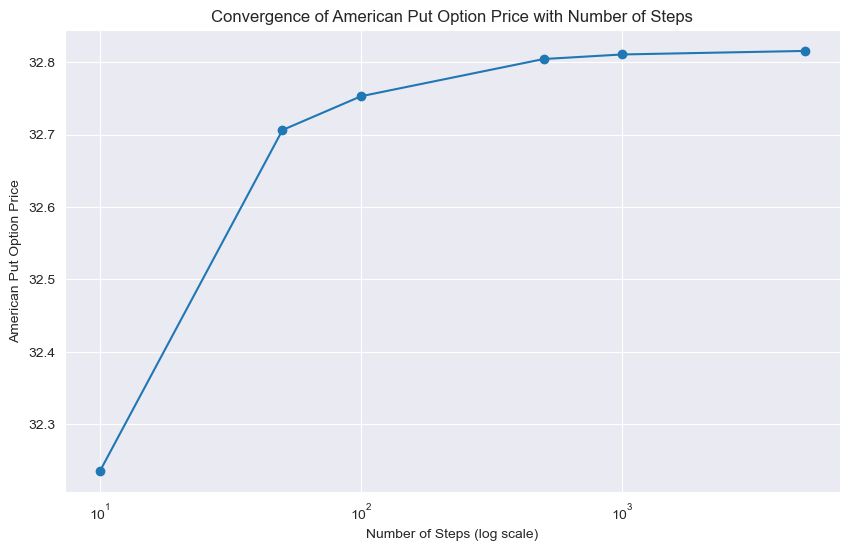

In [ ]:
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
T = 10         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
n_steps = [10, 50, 100, 500, 1000, 5000]  # Number of steps in binomial tree

# Plot the result
steps_list = []
american_put_prices = []
for steps in n_steps:
    put_binomial_tree = BinomialTreeSimulator(S0, K, T, r, sigma, n_steps=steps, option_type='put')
    american_put_price_binomial = put_binomial_tree.price_american_option()
    steps_list.append(steps)
    american_put_prices.append(american_put_price_binomial)
plt.figure(figsize=(10, 6))
plt.plot(steps_list, american_put_prices, marker='o')
plt.xscale('log')
plt.xlabel('Number of Steps')
plt.ylabel('American Put Option Price')
plt.title('Convergence of American Put Option Price with Number of Steps')
plt.grid(True)
plt.show()

# Longstaff-Schwarz algorithm

The Longstaff-Schwartz algorithm is a Monte Carlo method for pricing American options. It uses least squares regression to estimate the continuation value of the option at each time step.

## Algorithm Steps:

1. **Simulate Stock Price Paths**: Generate many paths of the underlying asset using geometric Brownian motion
2. **Initialize Cash Flows**: Set terminal payoffs at expiration
3. **Backward Induction**: Work backwards from expiration:
   - For each time step, identify in-the-money paths
   - Use regression to estimate continuation value based on current stock price
   - Compare immediate exercise value vs. continuation value
   - Exercise if immediate value > continuation value
4. **Discount to Present**: Calculate the option value by discounting cash flows

## Key Features:

- **Basis Functions**: Uses Laguerre polynomials to capture the relationship between stock price and continuation value
- **Regression**: Least squares regression estimates continuation value for in-the-money paths only
- **Early Exercise**: Determines optimal exercise policy by comparing exercise vs. continuation values

The algorithm is particularly useful for path-dependent options and high-dimensional problems where binomial trees become computationally expensive.

In [57]:
test = np.array([1,3,2,4,5])
np.where(test % 2 == 1)[0]

array([0, 1, 4])

In [9]:
from src.stock_path_simulator import StockPathSimulator

class LongstaffSchwartzSimulator(StockPathSimulator):
    def __init__(self, S0, K, T, r, sigma, n_sims, n_steps, option_type='put'):
        super().__init__(S0=S0, sigma=sigma, T=T, r=r, mu=0, n_sims=n_sims, n_steps=n_steps)  # mu=0 for risk-neutral
        self.K = K
        self.option_type = option_type.lower()
        self.dt = self.T / self.n_steps
        self.discount_factor = np.exp(-self.r * self.dt)

    def calculate_payoff(self, stock_prices):
        """Calculate option payoff"""
        if self.option_type == 'put':
            return np.maximum(self.K - stock_prices, 0)
        elif self.option_type == 'call':
            return np.maximum(stock_prices - self.K, 0)
        else:
            raise ValueError("option_type must be 'put' or 'call'")
    
    def basis_functions(self, stock_prices):
        """
        Define basis functions for regression
        Using weighted Laguerre polynomials as in the original Longstaff-Schwartz paper
        """
        x = stock_prices / self.K  # Normalize by strike price
        
        # Weighted Laguerre polynomials with exponential factor e^(-x/2)
        # L0(x) = e^(-x/2), L1(x) = e^(-x/2)(1-x), L2(x) = e^(-x/2)(1-2x+x²/2)
        exp_factor = np.exp(-x / 2)
        L0 = exp_factor
        L1 = exp_factor * (1 - x)
        L2 = exp_factor * (1 - 2*x + 0.5*x**2)
        
        return np.column_stack([L0, L1, L2])
    
    def price_american_option(self):
        """
        Price American option using Longstaff-Schwartz algorithm
        """
        cash_flows = np.zeros((self.n_sims, self.n_steps + 1))

        # Step 1: Payoff at maturity
        cash_flows[:, -1] = self.calculate_payoff(self.stock_paths[:, -1])

        # Backward induction
        for t in range(self.n_steps - 1, 0, -1):
            # Consider early exercise at time t

            # Step 2: Calculate immediate exercise value
            exercise_value = self.calculate_payoff(self.stock_paths[:, t])
            # Find paths where immediate exercise is profitable (in-the-money)
            in_the_money = exercise_value > 0
            if np.sum(in_the_money) == 0:
                continue  # No paths are in-the-money, skip to next time step

            # Step 3: For in the money paths, estimate continuation value using regression
            # We want regression E(Y|X), where Y is the discounted cash flows from t+1 onward given stock price X at time t
            # This is the same notation in the Longstaff-Schwartz paper

            if len(np.where(in_the_money)[0]) < 3:
                # Not enough points to perform regression
                continue
            else:
                # Prepare regression data
                # For Y, we look at the maximum cash flow from t+1 onward for each path
                Y = np.zeros(np.sum(in_the_money))
                for i, path_idx in enumerate(np.where(in_the_money)[0]):
                    # Find the next non-zero cash flow for this path
                    future_cf_times = np.where(cash_flows[path_idx, t+1:] > 0)[0]
                    if len(future_cf_times) >= 2:
                        raise ValueError("Multiple future cash flows found, which should not happen in Longstaff-Schwartz.")
                    if len(future_cf_times) > 0:
                        next_cf_time = future_cf_times[0] + t + 1
                        discount_periods = next_cf_time - t
                        Y[i] = (cash_flows[path_idx, next_cf_time] * 
                                        (self.discount_factor ** discount_periods))

                X = self.basis_functions(self.stock_paths[in_the_money, t])

                # Regression to estimate continuation value
                try:
                    beta = np.linalg.lstsq(X, Y, rcond=None)[0]
                    continuation_values = X @ beta
                except np.linalg.LinAlgError:
                    raise ValueError("Regression failed at time step", t)
            
            # Step 4: Decide whether to exercise or continue
            itm_exercise_values = exercise_value[in_the_money]
            exercise_now = itm_exercise_values > continuation_values
            itm_indices = np.where(in_the_money)[0]
            exercise_indices = itm_indices[exercise_now]

            # Set cash flows for paths where we exercise now
            cash_flows[:, t] = 0  # Reset current time cash flows
            cash_flows[exercise_indices, t] = exercise_value[exercise_indices]

            # Clear future cash flows for paths where we exercise now
            # The logic is that if we want to exercise now, we cannot exercise later
            for idx in exercise_indices:
                cash_flows[idx, t+1:] = 0


        # Calculate option value at t=0
        # Discount all cash flows back to present value
        option_values = np.zeros(self.n_sims)
        for path in range(self.n_sims):
            cf_times = np.where(cash_flows[path, :] > 0)[0]
            if len(cf_times) > 0:
                cf_time = cf_times[0]  # First (and should be only) cash flow time
                option_values[path] = (cash_flows[path, cf_time] * 
                                     (self.discount_factor ** cf_time))
                
        return np.mean(option_values)


    def price_european_option_mc(self):
        """Price European option using Monte Carlo for comparison"""
        terminal_payoffs = self.calculate_payoff(self.stock_paths[:, -1])
        discounted_payoffs = terminal_payoffs * (self.discount_factor ** self.n_steps)
        return np.mean(discounted_payoffs)

In [10]:
n_paths = 1000 # Number of Monte Carlo paths
n_mc_steps = 500   # Number of time steps for Monte Carlo
ls_call = LongstaffSchwartzSimulator(S0, K, T, r, sigma, n_paths, n_mc_steps, 'call')

print(f"K = {K}")

print(ls_call.price_american_option())

print(ls_call.price_european_option_mc())

K = 140
53.852665472708985
69.63361697196935


In [11]:
# Test the Longstaff-Schwartz algorithm
n_paths = 1000 # Number of Monte Carlo paths
n_mc_steps = 500   # Number of time steps for Monte Carlo

print("=== LONGSTAFF-SCHWARTZ ALGORITHM RESULTS ===")

# PUT option using Longstaff-Schwartz
ls_put = LongstaffSchwartzSimulator(S0, K, T, r, sigma, n_paths, n_mc_steps, 'put')
american_put_ls = ls_put.price_american_option()
european_put_ls = ls_put.price_european_option_mc()

print(f"American Put Price (Longstaff-Schwartz): {american_put_ls:.4f}")
print(f"European Put Price (Longstaff-Schwartz MC): {european_put_ls:.4f}")
european_put_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'put')
print(f"European Put Option Price from Black-Scholes: {european_put_price_black_scholes:.4f}")
print(f"Early Exercise Premium (LS): {american_put_ls - european_put_ls:.4f}")

print(f"NOTE: This tends to be negative—I suspect this is numerical issues.")

# CALL option using Longstaff-Schwartz
ls_call = LongstaffSchwartzSimulator(S0, K, T, r, sigma, n_paths, n_mc_steps, 'call')
american_call_ls = ls_call.price_american_option()
european_call_ls = ls_call.price_european_option_mc()

print(f"\nAmerican Call Price (Longstaff-Schwartz): {american_call_ls:.4f}")
print(f"European Call Price (Longstaff-Schwartz MC): {european_call_ls:.4f}")
european_call_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'call')
print(f"European Call Option Price from Black-Scholes: {european_call_price_black_scholes:.4f}")
print(f"Early Exercise Premium (LS): {american_call_ls - european_call_ls:.4f}")

print("\n=== COMPARISON WITH BINOMIAL TREE ===")
print(f"American Put - Binomial Tree: {american_put_price_binomial:.4f}")
print(f"American Put - Longstaff-Schwartz: {american_put_ls:.4f}")
print(f"Put Price Difference: {abs(american_put_price_binomial - american_put_ls):.4f}")

print(f"\nAmerican Call - Binomial Tree: {american_call_price_binomial:.4f}")
print(f"American Call - Longstaff-Schwartz: {american_call_ls:.4f}")
print(f"Call Price Difference: {abs(american_call_price_binomial - american_call_ls):.4f}")

print(f"\n=== COMPARISON WITH BLACK-SCHOLES (EUROPEAN) ===")
print(f"European Put - Black-Scholes: {european_put_price_black_scholes:.4f}")
print(f"European Put - Longstaff-Schwartz MC: {european_put_ls:.4f}")
print(f"Put Price Difference: {abs(european_put_price_black_scholes - european_put_ls):.4f}")

print(f"\nEuropean Call - Black-Scholes: {european_call_price_black_scholes:.4f}")
print(f"European Call - Longstaff-Schwartz MC: {european_call_ls:.4f}")
print(f"Call Price Difference: {abs(european_call_price_black_scholes - european_call_ls):.4f}")

=== LONGSTAFF-SCHWARTZ ALGORITHM RESULTS ===
American Put Price (Longstaff-Schwartz): 33.7787
European Put Price (Longstaff-Schwartz MC): 26.1277
European Put Option Price from Black-Scholes: 25.5339
Early Exercise Premium (LS): 7.6511
NOTE: This tends to be negative—I suspect this is numerical issues.

American Call Price (Longstaff-Schwartz): 44.9653
European Call Price (Longstaff-Schwartz MC): 68.0632
European Call Option Price from Black-Scholes: 66.8776
Early Exercise Premium (LS): -23.0979

=== COMPARISON WITH BINOMIAL TREE ===
American Put - Binomial Tree: 32.8105
American Put - Longstaff-Schwartz: 33.7787
Put Price Difference: 0.9683

American Call - Binomial Tree: 66.8664
American Call - Longstaff-Schwartz: 44.9653
Call Price Difference: 21.9010

=== COMPARISON WITH BLACK-SCHOLES (EUROPEAN) ===
European Put - Black-Scholes: 25.5339
European Put - Longstaff-Schwartz MC: 26.1277
Put Price Difference: 0.5937

European Call - Black-Scholes: 66.8776
European Call - Longstaff-Schwar

While the put option seems accurate, the call option is consistently lower at larger values of simulation. I suspect this is a problem of the algorithm's approximation—for sufficiently long runs, some path would erroneously perform early exercise due to the regression, suppressing the output.